In [9]:
# This is just creating a sample synthetic topo file
# Creating synthetic topo files (From the elevation profile of sample sites by fitting splines)
import numpy as np
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt

#%%
import pandas as pd
import os
datadir = os.path.join('/home/jovyan/data/hydroinformatics/syn_topo/data') # directory for some sample data files
#filename = 'Elevation_profile2.csv'
filename = "Shallotte_profile.csv"
filepath = os.path.join(datadir, filename)
df = pd.read_csv(filepath)

#%%
elev = df.loc[:,'Elevation']
dist = (df.loc[:,'X_axis']-1)*3
dist = (dist-max(dist))*(-1)
#%%
#Create spline model

cs = CubicSpline(dist,elev)

syn_elev = cs(dist)


#%%
# Making it 3D

y = dist.to_numpy()
# x = np.linspace(0,5,num=len(y))
x = y
z = np.zeros((len(x),len(y)))
xyz = np.zeros((1,3))


#%%
# Defining the shorline shoreline (z=0 contour)
below_sl = elev<0
below_sl = below_sl.to_numpy()
base_shore = int(max(np.argwhere(below_sl)))
y_bs = y[base_shore]
x_max = max(x)
y_max = max(y)
s = y_bs+5000*abs(np.sin(x*2*np.pi/x_max)) #curved with point
# add in triangular bay centered at x = x_bay
# s = y*0
# x_bay = x_max/2
# bay_width = 1000
# bay_height = 5000
# out_bay = np.logical_or(x<(x_bay-bay_width/2),x>(x_bay+bay_width/2))
# in_bay = out_bay==False
# s[out_bay]= y_bs
# s[in_bay] = y_bs+5000-abs(x[in_bay]-x_bay)*bay_height/(bay_width/2)
# plt.plot(x,s)
# plt.ylim([0,30000])
#%%

col=1
# to make 2d grid of z values
for col in range(z.shape[0]):
    # z[:,col]=syn_elev*abs(np.sin(10*x[col]))
    # z[:,col]=syn_elev*x[col]
    # z[:,col]=syn_elev+5*(np.sin(x[col]*np.pi/x_max))
    z[:,col]=syn_elev
    # ynew = y-s[col]+y_bs
    # ynew[ynew<0]=0
    # ynew[ynew>y_max]=y_max
    # z[:,col]=cs(ynew)
x
y

array([    0,     3,     6, ..., 30054, 30057, 30060])

In [10]:
# This is just to see if the code is working well
# Making a subset of the synthetic topo file
xis = np.linspace(0,len(x),num = 50,endpoint=False).astype(int)
yis = np.linspace(0,len(y),num = 50,endpoint=False).astype(int)
zis = np.meshgrid(xis,yis,indexing = 'ij')
zsub = z[zis]
zsub = np.flip(zsub)
# Checking the size of the file
zsub.shape

<ipython-input-10-a20d0306a9ff>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  zsub = z[zis]


(50, 50)

In [ ]:
# This is where we use the topo tool
from __future__ import print_function
from clawpack.geoclaw import topotools
import os
CLAW = os.environ['CLAW']
datadir = os.path.join(CLAW,'geoclaw','scratch') # directory for some sample data files
import netCDF4

topo_file_syn = topotools.Topography()
topo_file_syn.x = x
topo_file_syn.y = y
topo_file_syn.Z = z

syn_file_dir = '/home/jovyan/data/topo_files_output/'
outfile = os.path.join(syn_file_dir, 'Topo_syn.nc' )

topo_file_syn.write(outfile, topo_type=4)

<AxesSubplot:>

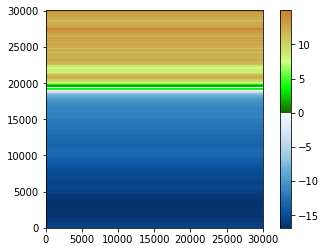

In [5]:
# Here I plot the file

import numpy
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from clawpack.visclaw import plottools
import clawpack.visclaw.colormaps as colormaps
import clawpack.geoclaw.topotools as tt

syn_file_dir = '/home/jovyan/data/topo_files_output/'
path = os.path.join(syn_file_dir, 'Topo_syn.nc' )

# Load topography
topo = tt.Topography(path, topo_type=4)

# Plot settings
data_break = 0.0
topo_extent = (numpy.min(topo.Z), numpy.max(topo.Z))
region_extent = topo.extent

# Make colormap
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                                 0.25:[0.0,1.0,0.0],
                                                  0.5:[0.8,1.0,0.5],
                                                  1.0:[0.8,0.5,0.2]})
sea_cmap = plt.get_cmap('Blues_r')
cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap), 
                                     data_limits=topo_extent,
                                     data_break=data_break)

# Plot topo
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
plot = plottools.pcolorcells(topo.X, topo.Y, topo.Z, axes=axes, norm=norm, cmap=cmap)
cbar = plt.colorbar(plot, ax=axes)

# expand extent to include full cells, which are centered at X,Y:
x1 = topo.x.min() - topo.delta[0]/2.
x2 = topo.x.max() + topo.delta[0]/2.
y1 = topo.y.min() - topo.delta[1]/2.
y2 = topo.y.max() + topo.delta[1]/2.

axes.set_xlim(x1,x2)
axes.set_ylim(y1,y2)

# Set aspect
mean_coord = 0.5 * (region_extent[3] + region_extent[2])
# axes.set_aspect(1.0 / numpy.cos(numpy.pi / 180.0 * mean_lat))
axes.set_aspect('equal')

plt.show()


<ipython-input-6-b24f00d0998c>:257: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  zsub = z[zis]


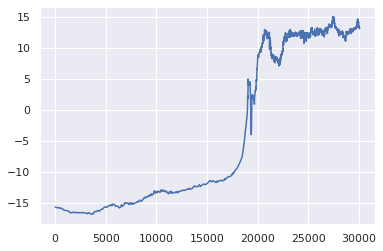

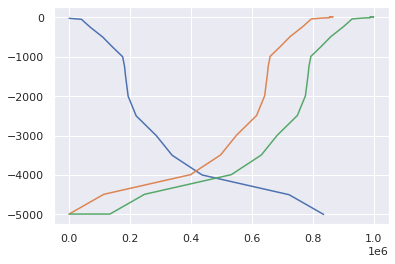

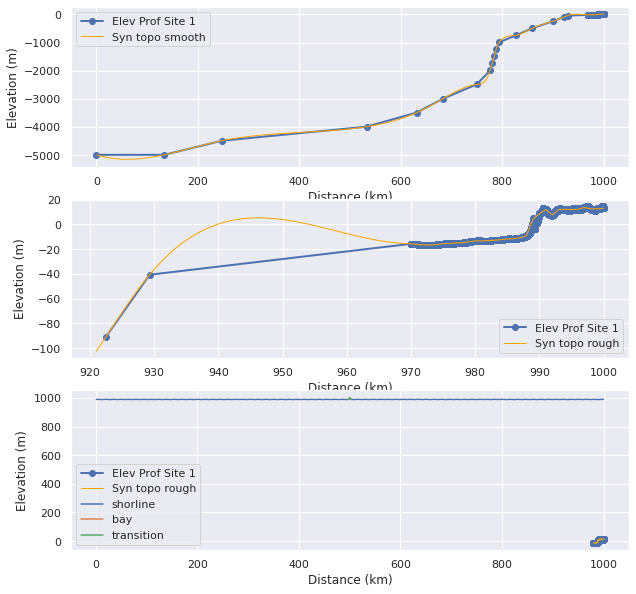

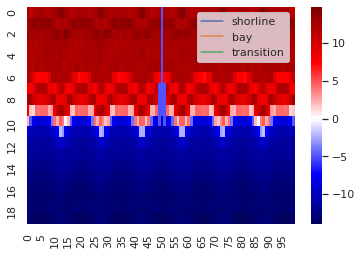

In [6]:
# This is loading the coarse topography (# 5000 km x 5000 km)
# -*- coding: utf-8 -*-


In [8]:
# This is where we use the topo tool for coarse topography
from __future__ import print_function
from clawpack.geoclaw import topotools
import os
CLAW = os.environ['CLAW']
datadir = os.path.join(CLAW,'geoclaw','scratch') # directory for some sample data files
import netCDF4

topo_file_syn = topotools.Topography()
topo_file_syn.x = x
topo_file_syn.y = y
topo_file_syn.Z = z

syn_file_dir = '/home/jovyan/data/topo_files_output/'
outfile = os.path.join(syn_file_dir, 'Coarse_topo_1000km.nc' )

topo_file_syn.write(outfile, topo_type=4)


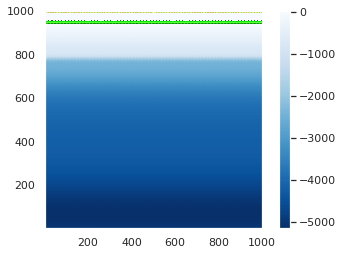

In [11]:
# Here I plot the coarse topo file

import numpy
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from clawpack.visclaw import plottools
import clawpack.visclaw.colormaps as colormaps
import clawpack.geoclaw.topotools as tt

syn_file_dir = '/home/jovyan/data/topo_files_output/'
path = os.path.join(syn_file_dir, 'Coarse_topo_1000km.nc' )

# Load topography
topo = tt.Topography(path, topo_type=4)

# Plot settings
data_break = 0.0
topo_extent = (numpy.min(topo.Z), numpy.max(topo.Z))
region_extent = topo.extent

# Make colormap
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                                 0.25:[0.0,1.0,0.0],
                                                  0.5:[0.8,1.0,0.5],
                                                  1.0:[0.8,0.5,0.2]})
sea_cmap = plt.get_cmap('Blues_r')
cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap), 
                                     data_limits=topo_extent,
                                     data_break=data_break)

# Plot topo
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
plot = plottools.pcolorcells(topo.X, topo.Y, topo.Z, axes=axes, norm=norm, cmap=cmap)
cbar = plt.colorbar(plot, ax=axes)

# expand extent to include full cells, which are centered at X,Y:
x1 = topo.x.min() - topo.delta[0]/2.
x2 = topo.x.max() + topo.delta[0]/2.
y1 = topo.y.min() - topo.delta[1]/2.
y2 = topo.y.max() + topo.delta[1]/2.

axes.set_xlim(x1,x2)
axes.set_ylim(y1,y2)

# Set aspect
mean_coord = 0.5 * (region_extent[3] + region_extent[2])
# axes.set_aspect(1.0 / numpy.cos(numpy.pi / 180.0 * mean_lat))
axes.set_aspect('equal')

plt.show()


<ipython-input-3-e397eaa861e6>:266: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  zsub = z[zis]


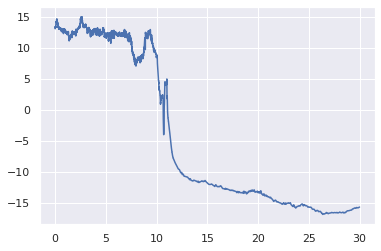

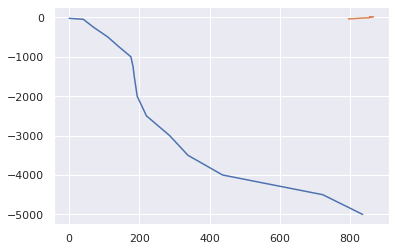

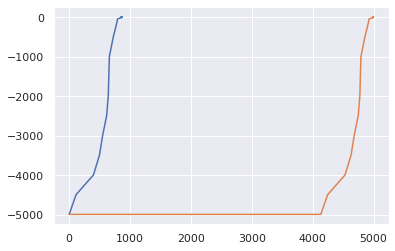

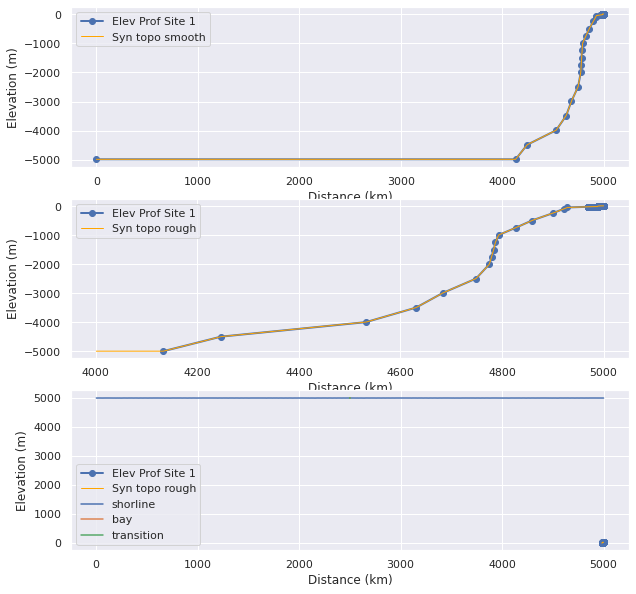

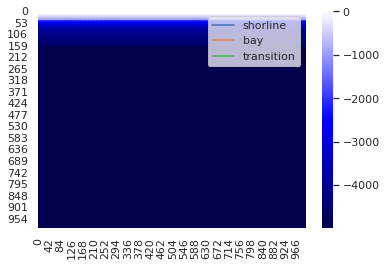

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 24 10:36:17 2021

@author: Research_Lab
"""
# Updated Coarse Topo File

import numpy as np
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()
from scipy.interpolate import interp1d

#%%
import pandas as pd
import os
datadir = os.path.join('/home/jovyan/data/hydroinformatics/syn_topo/data/Elevation_profile_30km/') # directory for some sample data files
#filename = 'Elevation_profile2.csv'
filename = "Shallotte_NC.csv"
file2 = "OceanDepth.csv"
filepath = os.path.join(datadir, filename)
filepath2 = os.path.join(datadir, file2)
df = pd.read_csv(filepath)
df2 = pd.read_csv(filepath2)
df2 = df2.loc[0:16,:]

#%%
elev = df.loc[:,'Elevation']
dist = df.loc[:,'Distance']
elev = elev[0:10001]
dist = dist[0:10001]
elev2 = df2.loc[:,'dpeth']
dist2 = df2.loc[:,'X-axis']
#%%

elev = elev.to_numpy() 
elev2 = elev2.to_numpy()
dist = dist.to_numpy()/1000 #changed to kilometers
dist2=dist2.to_numpy()/1000

#%%
plt.plot(dist,elev)
plt.figure()
plt.plot(dist2,elev2)

#%%

#making the two match up


elev = np.flip(elev)
elev2 = elev2+elev[0]-elev2[0]
dist=dist+max(dist2)+1

# dist = np.flip(dist)
dist2 = np.flip(dist2)
elev2 = np.flip(elev2)
dist2 = (dist2-max(dist2))*(-1)


elev = np.concatenate([elev2,elev])
dist = np.concatenate([dist2,dist])
plt.plot(dist[15:10037],elev[15:10037])
plt.figure()
plt.plot(dist,elev)

#%%

# make length = 10,000 km

dim = 5000

dist = dist + dim- max(dist)
dist =np.append(0,dist)
elev = np.append(min(elev),elev)
plt.plot(dist,elev)
#%%
#Create mathematical model

# cs = CubicSpline(dist,elev)
# us = UnivariateSpline(dist, elev)
interp = interp1d(dist, elev)

y = np.linspace(1,dim,num=dim)
syn_elev = interp(y)
# syn_elev2 = us(y)


#%%

#Generating Plots

plt.figure(figsize=(10,10))
plt.subplot(3, 1, 1)
plt.plot(dist, elev, 'bo-', linewidth=2, label='Elev Prof Site 1')
plt.plot(y, syn_elev,color = 'orange', linewidth=1, label='Syn topo smooth')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(dist[dist>4000], elev[dist>4000],'bo-', linewidth=2, label='Elev Prof Site 1')
plt.plot(y[y>4000], syn_elev[y>4000], color = 'orange',linewidth=1, label='Syn topo rough')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.plot(dist[dist>4980], elev[dist>4980], 'bo-',linewidth=2, label='Elev Prof Site 1')
plt.plot(y[y>4980], syn_elev[y>4980], color = 'orange',linewidth=1, label='Syn topo rough')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.legend(loc='best')

#%%

#Generating Plots (Univariate spline)

# plt.figure()
# plt.subplot(3, 1, 1)
# plt.plot(dist, elev, 'bo-', linewidth=2, label='Elev Prof Site 1')
# plt.plot(y, syn_elev2,color = 'orange', linewidth=1, label='Syn topo smooth')
# plt.xlabel('Distance (km)')
# plt.ylabel('Elevation (m)')
# plt.legend(loc='best')

# plt.subplot(3, 1, 2)
# plt.plot(dist[dist>900], elev[dist>900],'bo-', linewidth=2, label='Elev Prof Site 1')
# plt.plot(y[y>900], syn_elev2[y>900], color = 'orange',linewidth=1, label='Syn topo rough')
# plt.xlabel('Distance (km)')
# plt.ylabel('Elevation (m)')
# plt.legend(loc='best')

# plt.subplot(3, 1, 3)
# plt.plot(dist[dist>980], elev[dist>980], 'bo-',linewidth=2, label='Elev Prof Site 1')
# plt.plot(y[y>980], syn_elev2[y>980], color = 'orange',linewidth=1, label='Syn topo rough')
# plt.xlabel('Distance (km)')
# plt.ylabel('Elevation (m)')
# plt.legend(loc='best')

#%%

# Need to fix model in range of y = 930 to 970

# cs2 = CubicSpline(dist[dist>925],elev[dist>925],bc_type='natural')
# y_upper = y[y>925]
# syn_elev_upper = cs2(y_upper)
# plt.plot(dist[dist>980], elev[dist>980], 'bo-',linewidth=2)
# plt.plot(y_upper[y_upper>980],syn_elev_upper[y_upper>980],color='orange')

# syn_elev[y>925]=syn_elev_upper

#%%
# Making it 3D

x = y
z = np.zeros((len(y),len(x)))
# xyz = np.zeros((1,3))

#%%
# Defining the shorline shoreline (z=0 contour)
below_sl = syn_elev<-5
base_shore = int(max(np.argwhere(below_sl)))
y_bs = y[base_shore]
x_max = max(x)
y_max = max(y)
x_max_fine = max(df['X_axis'])*3/1000

# s = np.ones(len(y))*y_bs # flat shore
# s = y_bs+2*abs(np.sin((x-x_max/2+x_max_fine/2)*np.pi/x_max_fine)) # one big curve
s = y_bs+2*abs(np.sin((x-x_max/2+x_max_fine/4)*2*np.pi/x_max_fine)) #curved with points

# add in triangular bay centered at x = x_bay
sb = np.empty((len(y)))
sb[:]=np.NaN
x_bay = x_max/2
bay_width = 4
bay_height = 8
out_bay = np.logical_or(x<(x_bay-bay_width/2),x>(x_bay+bay_width/2))
in_bay = out_bay==False
sb[out_bay]= np.NaN
sb[in_bay] = s[int(len(s)/2+bay_width/2)]+bay_height-abs(x[in_bay]-x_bay)*\
    bay_height/(bay_width/2)

# add in transition

trans = np.empty((len(y)))
trans[:]=np.NaN
trans_width = 1
out_trans = np.logical_or(x<(x_bay-bay_width/2-trans_width),x>(x_bay+bay_width/2+trans_width))
in_trans = out_trans==False
trans[out_trans]= np.NaN
trans[in_trans] = s[int(len(s)/2+(bay_width/2+trans_width))]+bay_height-\
    abs(x[in_trans]-x_bay)*bay_height/(bay_width/2)+trans_width*bay_height*2/bay_width

# add in river

river_width = bay_width/10
x_riv = np.logical_and(x > x_bay-river_width/2, x < x_bay+river_width/2)

plt.plot(x,s, label = 'shorline')
plt.plot(x,sb, label = 'bay')
plt.plot(x,trans, label = 'transition')
plt.legend()

sub = np.logical_and(x>2450,x<2550)
plt.figure()
plt.plot(x[sub],s[sub], label = 'shorline')
plt.plot(x[sub],sb[sub], label = 'bay')
plt.plot(x[sub],trans[sub], label = 'transition')
plt.legend()
# plt.ylim([0,30000])
#%%

col=1
# to make 2d grid of z values
for col in range(z.shape[1]):
    # z[:,col]=syn_elev*abs(np.sin(10*x[col]))
    # z[:,col]=syn_elev*x[col]
    # z[:,col]=syn_elev+5*(np.sin(x[col]*np.pi/x_max))
    # z[:,col]=syn_elev
    ynew = y-s[col]+y_bs
    ynew[ynew<0]=0
    ynew[ynew>y_max]=y_max
    z[:,col]=interp(ynew)
    if in_bay[col]==True:
        y_bay = np.logical_and(y>s[col],y<sb[col])
        z[y_bay,col]=-5
        if x_riv[col]==True:
            y_riv = y>sb[col]
            z[y_riv,col]=-5
    # if in_trans[col]==True:
    #     y_trans = np.logical_and(y>s[col],y<trans[col])
    #     y_trans2 = np.logical_and(y>s[col],y<trans[col])
    # z[:,col]=cs(y)


# to make xyz matrix
# for col in range(len(y)):
#     zs=syn_elev*abs(np.sin(10*y[col]))
#     ys = np.ones((len(dist)))
#     ys = ys*y[col]
#     new_vals = np.stack((x,ys,zs),axis = 1)
#     topo = np.append(topo,new_vals,axis=0)


#%%

#visualize cross sections

# xind = 0

# plt.plot(y[6000:7000],z[6000:7000,xind])
# plt.ylim((-10,10))

#%%

#heatmap
# xis = np.linspace(450,550,num = 100,endpoint=False).astype(int)
# yis = np.linspace(980,1000,num = 20,endpoint=False).astype(int)
xis = np.linspace(0,len(x),num = 1000,endpoint=False).astype(int)
yis = np.linspace(0,len(y),num = 1000,endpoint=False).astype(int)
zis = np.meshgrid(yis,xis,indexing = 'ij')
zsub = z[zis]
zsub = np.flip(zsub)
# sns.color_palette("crest", as_cmap=True)
# ax = sns.heatmap(np.flip(z),cmap='seismic',center=0)
ax = sns.heatmap(zsub,cmap='seismic',center=0)


In [8]:
import numpy
x = numpy.linspace(1, 10, 10)
y = numpy.linspace(-40, -30, 100)
x

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])